# Imports 

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import csv
import emoji
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import joblib
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading the data

In [2]:
df = pd.read_csv(r"C:\Users\HP\Documents\Year I Semester II\SL\Project\Group 7 Pilot Dataset.csv")
df = df[['text', 'label']]

In [3]:
df.head()

,text,label
0,"Economic recovery and national climate pledges must be designed hand in hand this year if we are to combat the twin global crises we face, says @ manupulgarvidal # PetersbergClimateDialogue Photo credit; BMU/Christoph Wehrerpic.twitter.com/8j85FD6HhW",0
1,"In this difficult time, it’s hard to connect with the natural world. So this # EarthDay, we’re appreciating nature from afar by highlighting a few of the amazing ways it works to help our # climate. # EarthDay2020pic.twitter.com/OcxaSLKnYx",0
2,"The decision to postpone # COP26, is unavoidable. Our collective priority must be to put health and lives first. But climate action must remain a non-negotiable global priority, says @ manupulgarvidal http://ow.ly/MMpd50z2CY2 @ wwf_media @ WWF @ VPerezCirera",0
3,"Japan - the world’s fifth largest emitter of greenhouse gases - had an opportunity to step up # ClimateAction. Instead, it submitted an unchanged # climate plan ( # NDC) to the UN. It must rethink its submission, says @ WWF's @ manupulgarvidal:http://ow.ly/UoMH50yZYm3",0
4,How can countries include # NatureBasedSolutions in their # Climate plans ( # NDCs)? Our new guidance offers 8 simple recommendations: https://wwf.panda.org/?361395/NDCs-nature-based-solutions …pic.twitter.com/T4I1mSuM73,0


# Exploratory Data Analysis
#### Target variable

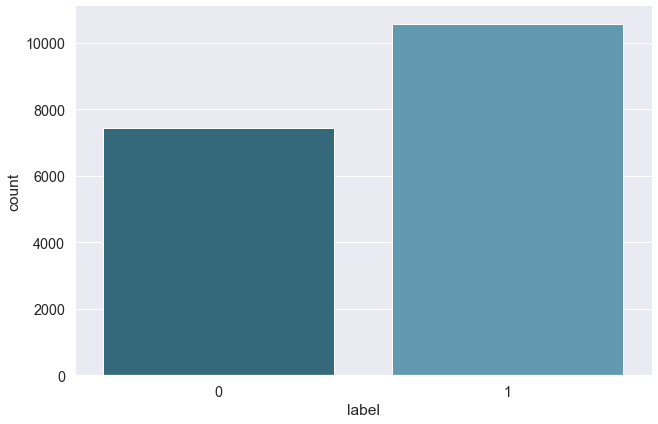

In [4]:
sns.factorplot(x="label", data=df, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show() # The class labels are imbalanced. One first approach is to undersample the majority class and oversample 
# the minority one, so as to obtain a more balanced dataset. 
# Other approach can be using other error metrics beyond accuracy such as the precision, the recall or the F1-score.

#### Input variable

In [5]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words # number of words in the tweet
                           , 'count_mentions': count_mentions # referrals to other Twitter accounts start with a @
                           , 'count_hashtags': count_hashtags # number of tag words, preceded by a #
                           , 'count_capital_words': count_capital_words # number of uppercase words are sometimes 
                                                                       #used to “shout” and express (negative) emotions
                           , 'count_excl_quest_marks': count_excl_quest_marks # number of question or exclamation marks
                           , 'count_urls': count_urls # number of links in the tweet, preceded by http(s)
                           , 'count_emojis': count_emojis # number of emoji, which might be a good sign of the sentiment
                          }) 
        
        return df
tc = TextCounts()
df_eda = tc.fit_transform(df.text)
df_eda['label'] = df.label

In [6]:
df_eda.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,label
0,36,0,0,1,0,0,0,0
1,40,0,0,0,0,0,0,0
2,37,0,0,1,0,1,0,0
3,41,0,0,3,0,1,1,0
4,30,0,0,0,2,1,0,0


In [7]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('label')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='label', size=5, hue='label', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
         count       mean        std  min   25%   50%   75%   max
label                                                            
0      7438.0   32.444743  13.307175  1.0  22.0  31.0  43.0  84.0
1      10571.0  24.912402  11.330541  4.0  17.0  22.0  30.0  92.0


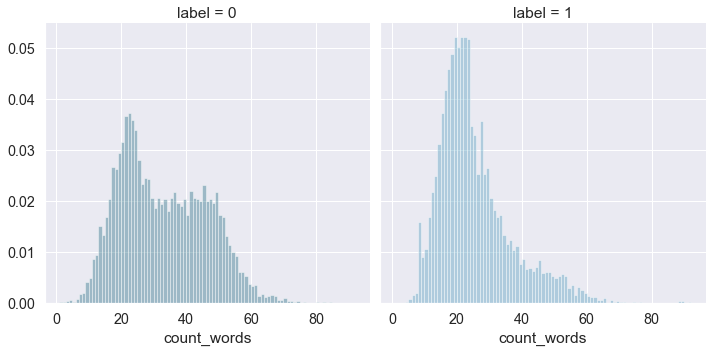

In [8]:
show_dist(df_eda,"count_words")

Descriptive stats for count_mentions
------------------------------------
         count      mean       std  min  25%  50%  75%   max
label                                                       
0      7438.0   0.611589  1.281475  0.0  0.0  0.0  1.0  17.0
1      10571.0  0.004919  0.083527  0.0  0.0  0.0  0.0  2.0 


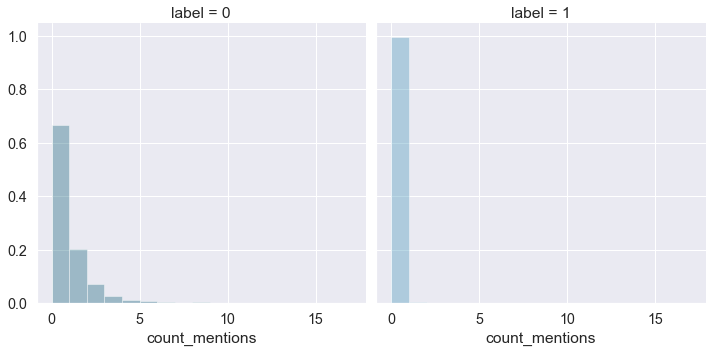

In [9]:
show_dist(df_eda,"count_mentions") # big difference, could be a fault of the database

Descriptive stats for count_hashtags
------------------------------------
         count      mean       std  min  25%  50%  75%   max
label                                                       
0      7438.0   0.924173  1.419302  0.0  0.0  0.0  2.0  18.0
1      10571.0  0.011257  0.109898  0.0  0.0  0.0  0.0  2.0 


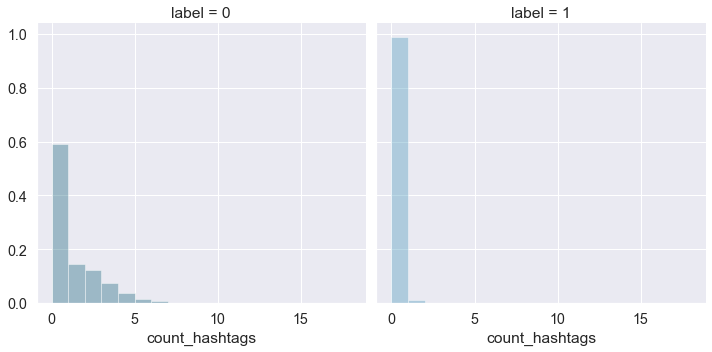

In [10]:
show_dist(df_eda,"count_hashtags") # huge difference 

Descriptive stats for count_capital_words
-----------------------------------------
         count      mean       std  min  25%  50%  75%   max
label                                                       
0      7438.0   0.543829  1.220660  0.0  0.0  0.0  1.0  30.0
1      10571.0  0.514332  1.250793  0.0  0.0  0.0  1.0  19.0


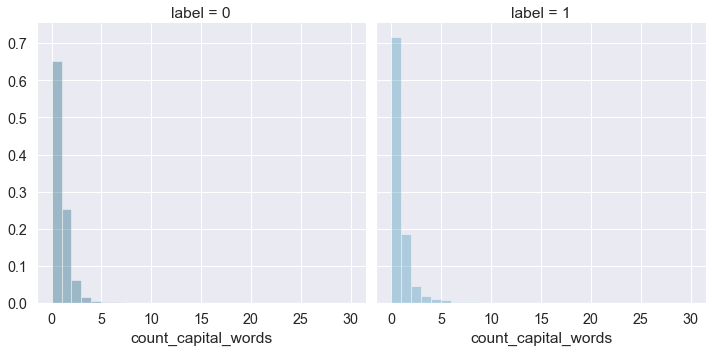

In [11]:
show_dist(df_eda,"count_capital_words") 

Descriptive stats for count_excl_quest_marks
--------------------------------------------
         count      mean       std  min  25%  50%  75%   max
label                                                       
0      7438.0   0.478892  0.825682  0.0  0.0  0.0  1.0  13.0
1      10571.0  0.277457  0.535514  0.0  0.0  0.0  0.0  10.0


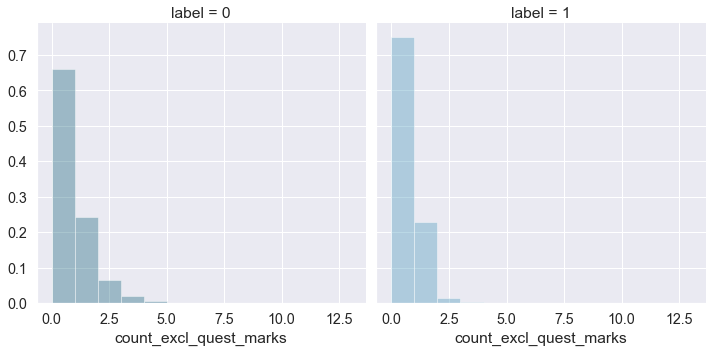

In [12]:
show_dist(df_eda,"count_excl_quest_marks")

Descriptive stats for count_urls
--------------------------------
         count      mean       std  min  25%  50%  75%  max
label                                                      
0      7438.0   0.697365  0.500607  0.0  0.0  1.0  1.0  4.0
1      10571.0  0.837574  0.395351  0.0  1.0  1.0  1.0  3.0


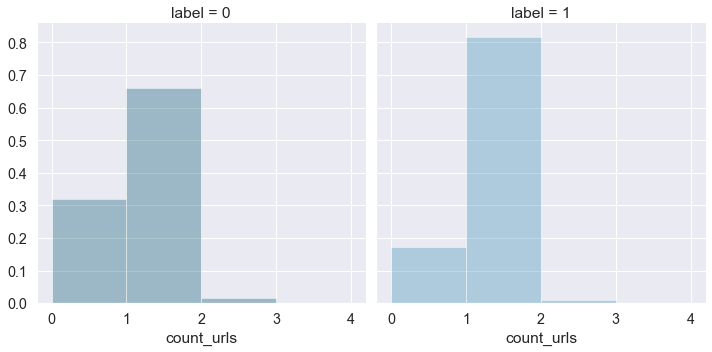

In [13]:
show_dist(df_eda,"count_urls")

Descriptive stats for count_emojis
----------------------------------
         count      mean       std  min  25%  50%  75%  max
label                                                      
0      7438.0   0.097472  0.380783  0.0  0.0  0.0  0.0  7.0
1      10571.0  0.124019  0.419083  0.0  0.0  0.0  0.0  6.0


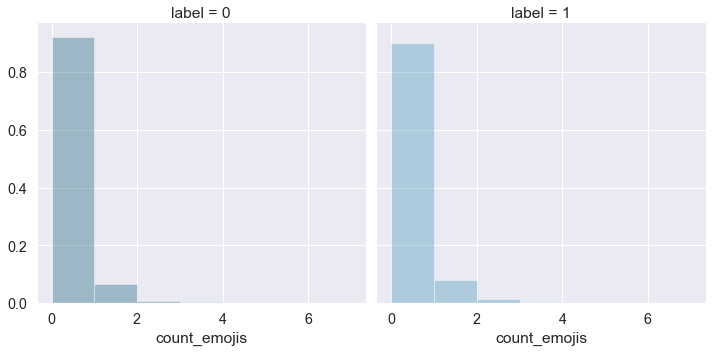

In [14]:
show_dist(df_eda,"count_emojis")

# Text Cleaning

In [15]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def possessive_pronouns(self, input_text):
        return input_text.replace("'s", "")
    
    def characters(self, input_text):
        input_text = input_text.replace("\r", " ")
        input_text = input_text.replace("\n", " ")
        input_text = input_text.replace("    ", " ")
        input_text = input_text.replace('"', '')
        return input_text
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def translator(self, input_text):
        '''this function transforms abbrevations to normal words'''
        input_text = input_text.split(" ")
        j = 0
        for _str in input_text:
            # File path which consists of Abbreviations.
            fileName = r"C:\Users\HP\Documents\Year I Semester II\SL\Project\StatLearnProj-master\Iason\slang.txt"
            # File Access mode [Read Mode]
            accessMode = "r"
            with open(fileName, accessMode) as myCSVfile:
                # Reading file as CSV with delimiter as "=", so that abbreviation are stored in row[0] and phrases in row[1]
                dataFromFile = csv.reader(myCSVfile, delimiter="=")
                # Removing Special Characters.
                _str = re.sub('[^a-zA-Z0-9-_.]', '', _str)
                for row in dataFromFile:
                    # Check if selected word matches short forms[LHS] in text file.
                    if _str.upper() == row[0]:
                        # If match found replace it with its appropriate phrase in text file.
                        input_text[j] = row[1]
                myCSVfile.close()
            j = j + 1
        # Replacing commas with spaces for final output.
    #     print(' '.join(input_text))
    #     print('===================================================')
    #     print('')
        return(' '.join(input_text))
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.translator).apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming).apply(self.characters).apply(self.possessive_pronouns)
        return clean_X

In [16]:
ct = CleanText()
sr_clean = ct.fit_transform(df.text)

In [17]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))

1 records have no words left after text cleaning


In [18]:
df[empty_clean] # this tweet with the cleaning is left to nothing. So we'll remove it 

,text,label
3087,@capital_climate :),0


In [19]:
df = df.drop(3087)

In [20]:
df.reset_index(inplace = True)
df.drop("index", axis = 1, inplace = True)

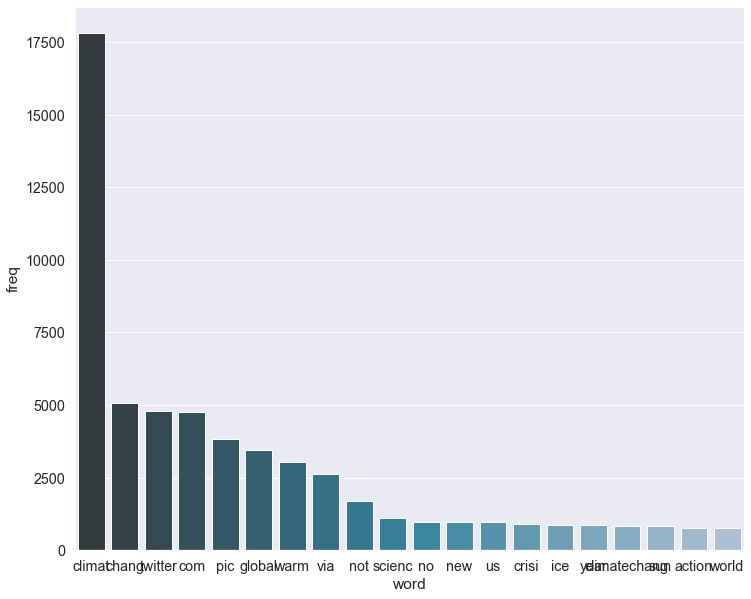

In [21]:
# most frequent words
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();
# here there are no, not, us etc. I don't know if we should remove them 

In [22]:
len(sr_clean) 

18009

In [23]:
len(df)

18008

In [24]:
sr_clean = sr_clean.drop(3087) # i deleted the 3087 from the df but not from the sr_clean
sr_clean

0        econom recoveri nation climat pledg must design hand hand year combat twin global crise face say manupulgarvid petersbergclimatedialogu photo credit bmu christoph wehrerp twitter com jfdhhw
1        difficult time it’ hard connect natur world earthday we’r appreci natur afar highlight amaz way work help climat earthdayp twitter com ocxaslknyx                                            
2        decis postpon cop unavoid collect prioriti must put health live first climat action must remain non negoti global prioriti say manupulgarvid wwfmedia wwf vperezcirera                       
3        japan world’ fifth largest emitt greenhous gase opportun step climateact instead submit unchang climat plan ndc un must rethink submiss say wwf manupulgarvid                                
4        countri includ naturebasedsolut climat plan ndc new guidanc offer simpl recommend …pic twitter com timsum                                                                                    
     

In [25]:
df

,text,label
0,"Economic recovery and national climate pledges must be designed hand in hand this year if we are to combat the twin global crises we face, says @ manupulgarvidal # PetersbergClimateDialogue Photo credit; BMU/Christoph Wehrerpic.twitter.com/8j85FD6HhW",0
1,"In this difficult time, it’s hard to connect with the natural world. So this # EarthDay, we’re appreciating nature from afar by highlighting a few of the amazing ways it works to help our # climate. # EarthDay2020pic.twitter.com/OcxaSLKnYx",0
2,"The decision to postpone # COP26, is unavoidable. Our collective priority must be to put health and lives first. But climate action must remain a non-negotiable global priority, says @ manupulgarvidal http://ow.ly/MMpd50z2CY2 @ wwf_media @ WWF @ VPerezCirera",0
3,"Japan - the world’s fifth largest emitter of greenhouse gases - had an opportunity to step up # ClimateAction. Instead, it submitted an unchanged # climate plan ( # NDC) to the UN. It must rethink its submission, says @ WWF's @ manupulgarvidal:http://ow.ly/UoMH50yZYm3",0
4,How can countries include # NatureBasedSolutions in their # Climate plans ( # NDCs)? Our new guidance offers 8 simple recommendations: https://wwf.panda.org/?361395/NDCs-nature-based-solutions …pic.twitter.com/T4I1mSuM73,0
...,...,...
18003,EXCLUSIVE: Study Finds Temperature Adjustments Account For â€˜Nearly All Of The Warmingâ€™ In Climate Data http://dailycaller.com/2017/07/05/exclusive-study-finds-temperature-adjustments-account-for-nearly-all-of-the-warming-in-climate-data/?utm_source=site-share â€¦,1
18004,Some good news. Wastefeul climate alarmist panel ended by @ realDonaldTrump admin. https://www.washingtonpost.com/news/energy-environment/wp/2017/08/20/the-trump-administration-just-disbanded-a-federal-advisory-committee-on-climate-change/ â€¦,1
18005,The EPA or the climate alarmist corporate crony program? https://twitter.com/EricLiptonNYT/status/901250216610983936 â€¦,1
18006,Will @ EPA and Justice Dept investigate the climate fraud scandal and associated potential loss of tax dollars? http://www.breitbart.com/big-government/2017/12/06/tidalgate-climate-alarmists-caught-faking-sea-level-rise/ â€¦,1


In [26]:
dopo_eda = pd.DataFrame()
dopo_eda["text"] = sr_clean
dopo_eda["label"] = df.label
dopo_eda

,text,label
0,econom recoveri nation climat pledg must design hand hand year combat twin global crise face say manupulgarvid petersbergclimatedialogu photo credit bmu christoph wehrerp twitter com jfdhhw,0.0
1,difficult time it’ hard connect natur world earthday we’r appreci natur afar highlight amaz way work help climat earthdayp twitter com ocxaslknyx,0.0
2,decis postpon cop unavoid collect prioriti must put health live first climat action must remain non negoti global prioriti say manupulgarvid wwfmedia wwf vperezcirera,0.0
3,japan world’ fifth largest emitt greenhous gase opportun step climateact instead submit unchang climat plan ndc un must rethink submiss say wwf manupulgarvid,0.0
4,countri includ naturebasedsolut climat plan ndc new guidanc offer simpl recommend …pic twitter com timsum,0.0
...,...,...
18004,exclus studi find temperatur adjust account â€˜nearli warmingâ€™ climat data â€¦,1.0
18005,good news wastefeul climat alarmist panel end realdonaldtrump admin â€¦,1.0
18006,epa climat alarmist corpor croni program â€¦,1.0
18007,epa justic dept investig climat fraud scandal associ potenti loss tax dollar â€¦,1.0


In [27]:
dopo_eda.to_csv("dopo_eda.csv")